In [16]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
if random.random() < (mean/160):
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
eDiscovery,521.194085,9.651742,43.726979,54
Ubuntu,307.288931,11.818805,57.037070,26
Network Terms,257.216479,17.147765,61.311786,15
"The Mines of the Behemoth, Shea",1234.806479,25.200132,117.355177,49
Exchange Online and Defender,1099.412611,28.190067,80.126762,39
"Everything is Tuberculosis, Green",746.870172,32.472616,127.716148,23
SSH + SCP,966.298496,33.320638,184.462485,29
Docker,1343.655940,43.343740,189.773622,31
Linux,1428.567039,44.642720,168.229415,32
WinHex,1035.001804,49.285800,166.859025,21


# Histogram

sum of ages: ~49153.44


<Axes: >

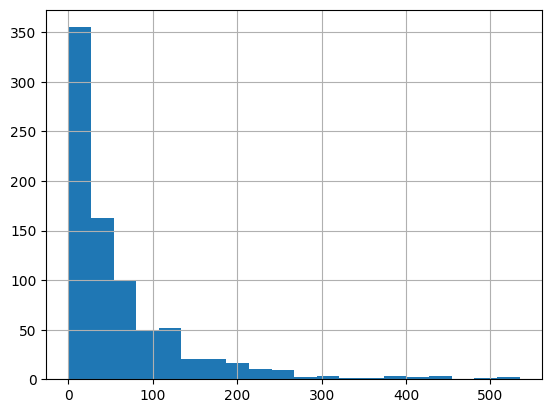

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49153.44


<Axes: >

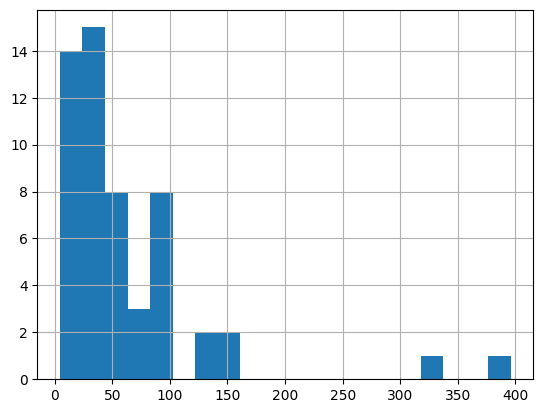

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 811
Total card age: 49153.44


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
210,Azure Files Documentation,"When using AD DS authentication, you assign sh...",c93dfdaf4065533896f6a7ba95b7d4ca,534.530132,83.184930,-534.530132,3826.506800,0.522523,46,0,0,-534.530132
483,Azure Files Documentation,The Kerberos authentication client is implemen...,d9d78220383e95f5f8155f911a8d65c0,509.911734,83.184930,-534.530132,3826.506800,0.522523,46,1,0,-509.911734
744,Azure Files Documentation,Soft delete is a storage-account level setting...,bbd0e2f9428537ee1ef7bf7506bf4ae0,331.166408,83.184930,-534.530132,3826.506800,0.522523,46,2,0,-331.166408
147,Terraform Codebox,CIFS (Common Internet File System)\nA network ...,121c60b48a3d689b6c1fde3868727aa2,482.255384,109.370669,-482.255384,3827.973400,0.547199,35,0,0,-482.255384
421,Terraform Codebox,Cloud-init is a standard way to initialize Lin...,784c88e3c53824bb061271636376695d,435.636979,109.370669,-482.255384,3827.973400,0.547199,35,1,0,-435.636979
683,Terraform Codebox,exercism configure\nA CLI command used to link...,ca713604b27c9413cd735061438bbcb1,413.450788,109.370669,-482.255384,3827.973400,0.547199,35,2,0,-413.450788
159,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,440.836121,105.123355,-440.836121,3784.440774,0.388170,36,0,0,-440.836121
433,JavaScript Concepts,Split a string and convert parts to numbers\n ...,e4c93ec49febdd31af930f9d8321ee49,381.181680,105.123355,-440.836121,3784.440774,0.388170,36,1,0,-381.181680
694,JavaScript Concepts,Unique Names: All JavaScript variables must be...,099c8b12d0430a9332a9942a81c022fb,256.770198,105.123355,-440.836121,3784.440774,0.388170,36,2,0,-256.770198
171,Node.js and Vite,Import Alias Validation (shadcn)\nshadcn check...,1a0e173e6fcc0c538da9bbb2d6113267,434.586652,89.998999,-434.586652,3239.963965,0.864939,36,0,0,-434.586652


## Card Count

In [26]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(4220.326074510232)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
210,Azure Files Documentation,"When using AD DS authentication, you assign sh...",c93dfdaf4065533896f6a7ba95b7d4ca,534.530132,83.184930,-534.530132,3826.506800,0.522523,46,0,0,-534.530132
483,Azure Files Documentation,The Kerberos authentication client is implemen...,d9d78220383e95f5f8155f911a8d65c0,509.911734,83.184930,-534.530132,3826.506800,0.522523,46,1,0,-509.911734
147,Terraform Codebox,CIFS (Common Internet File System)\nA network ...,121c60b48a3d689b6c1fde3868727aa2,482.255384,109.370669,-482.255384,3827.973400,0.547199,35,0,0,-482.255384
159,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,440.836121,105.123355,-440.836121,3784.440774,0.388170,36,0,0,-440.836121
421,Terraform Codebox,Cloud-init is a standard way to initialize Lin...,784c88e3c53824bb061271636376695d,435.636979,109.370669,-482.255384,3827.973400,0.547199,35,1,0,-435.636979
171,Node.js and Vite,Import Alias Validation (shadcn)\nshadcn check...,1a0e173e6fcc0c538da9bbb2d6113267,434.586652,89.998999,-434.586652,3239.963965,0.864939,36,0,0,-434.586652
683,Terraform Codebox,exercism configure\nA CLI command used to link...,ca713604b27c9413cd735061438bbcb1,413.450788,109.370669,-482.255384,3827.973400,0.547199,35,2,0,-413.450788
13,Django,Collectstatic Step\nPart of Django deployment ...,52e99cf555a329f05921f2a497c12457,412.147124,107.632211,-412.147124,1722.115368,0.506317,16,0,0,-412.147124
243,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,396.040464,61.209312,-396.040464,3305.302863,0.202685,54,0,0,-396.040464
433,JavaScript Concepts,Split a string and convert parts to numbers\n ...,e4c93ec49febdd31af930f9d8321ee49,381.181680,105.123355,-440.836121,3784.440774,0.388170,36,1,0,-381.181680


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 60.608'